In [ ]:
#This code is designed to test the performance of Logistic Regression and K-Nearest Neighbors (KNN) models. The evaluation metrics used include accuracy, F1-score, ROC AUC, and geometric mean (g-means). The number of neighbors (k) in KNN has been tuned to optimize the metrics, and the number of features has been tested in the Logistic Regression model to evaluate its performance.

In [127]:
# Import the packages we may need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from scipy.stats import sem
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score

In [128]:
# Read in the pancancer dataset
Pancancer_df=pd.read_csv("pancancer.csv")

C:\Users\simei\AppData\Local\Temp\ipykernel_10460\3217522199.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  Pancancer_df=pd.read_csv("pancancer.csv")


In [129]:
# Check what it looks like
Pancancer_df = pd.DataFrame(Pancancer_df)
Pancancer_df.head(5)

,Sample_ID,Cancer,Assay,OlinkID,UniProt,Panel,NPX
0,"""AML_1""","""AML""","""AARSD1""","""OID21311""","""Q9BTE6""","""Oncology""",5.01745
1,"""AML_2""","""AML""","""AARSD1""","""OID21311""","""Q9BTE6""","""Oncology""",2.8679
2,"""AML_3""","""AML""","""AARSD1""","""OID21311""","""Q9BTE6""","""Oncology""",4.58825
3,"""AML_4""","""AML""","""AARSD1""","""OID21311""","""Q9BTE6""","""Oncology""",1.97255
4,"""AML_5""","""AML""","""AARSD1""","""OID21311""","""Q9BTE6""","""Oncology""",3.45995


In [ ]:
# convert the NPX to numaric data type in order to use pivot_table later
Pancancer_df['NPX'] = pd.to_numeric(Pancancer_df['NPX'], errors='coerce')

In [ ]:
# remove the quote mark
Pancancer_df[["Sample_ID","Cancer","UniProt"]] = Pancancer_df[["Sample_ID","Cancer","UniProt"]].apply(lambda x: x.str.replace('"', '', regex=False))

In [19]:
Pancancer_df.head(5)

,Sample_ID,Cancer,Assay,OlinkID,UniProt,Panel,NPX
0,AML_1,AML,"""AARSD1""","""OID21311""",Q9BTE6,"""Oncology""",5.01745
1,AML_2,AML,"""AARSD1""","""OID21311""",Q9BTE6,"""Oncology""",2.86790
2,AML_3,AML,"""AARSD1""","""OID21311""",Q9BTE6,"""Oncology""",4.58825
3,AML_4,AML,"""AARSD1""","""OID21311""",Q9BTE6,"""Oncology""",1.97255
4,AML_5,AML,"""AARSD1""","""OID21311""",Q9BTE6,"""Oncology""",3.45995


In [133]:
Pancancer_pivot = Pancancer_df.pivot_table(index = ['Sample_ID', 'Cancer'], columns = 'UniProt', values = 'NPX' )
Pancancer_pivot.reset_index(inplace=True)
Pancancer_pivot.head(15)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,AML,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,AML,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,AML,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,AML,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,AML,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
5,AML_14,AML,0.08920,0.22545,-0.47415,1.83150,0.92420,6.56080,4.30555,0.92640,...,5.56885,2.46510,1.82050,6.14920,5.99445,1.44280,5.41060,0.41685,3.25440,1.09110
6,AML_15,AML,-0.07185,0.10130,-1.39720,3.05240,1.26085,5.36945,1.55795,2.40705,...,1.48585,2.23725,0.15615,2.42300,4.81290,0.49115,2.69765,0.45220,1.49335,1.31605
7,AML_16,AML,0.64490,-0.00030,-1.52450,0.76560,1.11520,1.03430,0.93625,2.18410,...,2.53005,1.27950,-0.38825,0.62780,2.90270,0.30915,1.44680,0.46245,1.34865,0.24400
8,AML_17,AML,0.11200,0.84130,-0.81540,0.51790,2.04955,1.60310,3.77460,-0.22100,...,NaN,NaN,1.16780,NaN,NaN,1.61305,2.62540,0.03750,2.35580,NaN
9,AML_18,AML,0.97170,0.61700,-1.53600,0.22060,1.15250,1.96905,-0.01260,3.56180,...,3.79465,1.84825,0.11195,0.87955,3.94285,-0.40650,1.03135,0.24875,2.67350,1.88915


In [134]:
# Combine all the blood cancers into one category
df_bloodcombined = Pancancer_pivot.copy(deep = True)
df_bloodcombined = df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )

In [135]:
df_bloodcombined.head(5)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,BLOOD,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,BLOOD,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,BLOOD,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,BLOOD,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,BLOOD,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [136]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC'}

In [137]:
# Specify the protein list 
proteins=df_bloodcombined.columns[2:]
# Check that we have the right number of proteins
proteins

Index(['A1E959', 'A1L4H1', 'A4D1B5', 'A6NI73', 'B1AKI9', 'NTproBNP', 'O00161',
       'O00175', 'O00182', 'O00186',
       ...
       'Q9Y653', 'Q9Y662', 'Q9Y680', 'Q9Y6A5', 'Q9Y6D9', 'Q9Y6E0', 'Q9Y6K9',
       'Q9Y6N7', 'Q9Y6Q6', 'Q9Y6Y9'],
      dtype='object', name='UniProt', length=1463)

In [138]:
# Encode the cancer types as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bloodcombined['Cancer'] = le.fit_transform(df_bloodcombined['Cancer'])

In [139]:
df_bloodcombined.head(5)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,0,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,0,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,0,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,0,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [140]:
# Split the data into X and y
X = df_bloodcombined[proteins]
y = df_bloodcombined['Cancer']

In [141]:
df_bloodcombined.Cancer.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [142]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size=0.2, random_state=100)

In [143]:
# Cross-validation parameters
n_splits = 5  # Number of folds
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
# Initialize KNNImputer for handling missing values
imputer = KNNImputer(n_neighbors=5, weights="uniform")

In [151]:
# Logistic regression train on the bloodcancer-combined pancancer datadset
log_accuracies = []
log_f1s = []
log_auc = []
log_gmeans = []

# k-Fold Cross-Validation Loop
for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    # Extract train and test sets for the current fold
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # use smote to balance the classes in y
    smote = SMOTE(random_state=100)
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # train models
    log_pip = Pipeline([("log", LogisticRegression(penalty='l1', solver='liblinear'))])
    log_pip.fit(resampled_X, resample_y)

    # Predict and evaluate logistic regression by various means
    log_y_pred = log_pip.predict(X_fold_test_imputed)
    log_y_pred_proba = log_pip.predict_proba(X_fold_test_imputed)
    log_fold_accuracy = accuracy_score(y_fold_test, log_y_pred)
    log_fold_gmean = geometric_mean_score(y_fold_test, log_y_pred, average='weighted')
    log_fold_auc = roc_auc_score(y_fold_test, log_y_pred_proba, multi_class='ovr', average='weighted')
    log_fold_f1 = f1_score(y_fold_test, log_y_pred, average='macro')
 
    # Calculate and store score for this fold
    log_accuracies.append(log_fold_accuracy)
    log_f1s.append(log_fold_f1)
    log_auc.append(log_fold_auc)
    log_gmeans.append(log_fold_gmean)

    # Print scores for this fold
    print(f"\nFold {i+1} - Logistic Regression Accuracy: {log_fold_accuracy:.4f}, F1 score: {log_fold_f1}, ROC AUC: {log_fold_auc}, gmean: {log_fold_gmean}")

# Display averaged scores
log_mean_accuracy = np.mean(log_accuracies)
log_mean_F1 = np.mean(log_f1s)
log_mean_AUC = np.mean(log_auc)
log_mean_gmeans = np.mean(log_gmeans)

print(f"\n For bloodcancer-combined pancancer dataset: ")
print(f"\n Logistic Regression Mean Accuracy: {log_mean_accuracy:.4f}, mean F1: {log_mean_F1}, mean_AUC: {log_mean_AUC}, mean gmean: {log_mean_gmeans}")


Fold 1 - Logistic Regression Accuracy: 0.7890, F1 score: 0.7796523973690229, ROC AUC: 0.9615419007368532, gmean: 0.8745445677224247

Fold 2 - Logistic Regression Accuracy: 0.7500, F1 score: 0.7356446843872388, ROC AUC: 0.9553870029665968, gmean: 0.8525316151690865

Fold 3 - Logistic Regression Accuracy: 0.7542, F1 score: 0.7358630848165988, ROC AUC: 0.953631928739006, gmean: 0.8540575415783792

Fold 4 - Logistic Regression Accuracy: 0.7797, F1 score: 0.7532682407114327, ROC AUC: 0.9573062033720082, gmean: 0.8699342014933629

Fold 5 - Logistic Regression Accuracy: 0.7585, F1 score: 0.7446398396304762, ROC AUC: 0.9577426825539652, gmean: 0.8565398566336332

 For bloodcancer-combined pancancer dataset: 

 Logistic Regression Mean Accuracy: 0.7663, mean F1: 0.7498136493829539, mean_AUC: 0.957121943673686, mean gmean: 0.8615215565193772


In [146]:
# KNN regression train on the bloodcancer-combined pancancer datadset

knn_accuracies = []
knn_f1s = []
knn_auc = []
knn_gmeans = []

# k-Fold Cross-Validation Loop
for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    # Extract train and test sets for the current fold
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # use smote to balance the classes in y
    smote = SMOTE(random_state=100)
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # train models
    knn_pip = Pipeline([("knn", KNeighborsClassifier(17))])
    knn_pip.fit(resampled_X, resample_y)

    # Predict and evaluate knnistic regression by various means
    knn_y_pred = knn_pip.predict(X_fold_test_imputed)
    knn_y_pred_proba = knn_pip.predict_proba(X_fold_test_imputed)
    knn_fold_accuracy = accuracy_score(y_fold_test, knn_y_pred)
    knn_fold_gmean = geometric_mean_score(y_fold_test, knn_y_pred, average='weighted')
    knn_fold_auc = roc_auc_score(y_fold_test, knn_y_pred_proba, multi_class='ovr', average='weighted')
    knn_fold_f1 = f1_score(y_fold_test, knn_y_pred, average='macro')
 
    # Calculate and store score for this fold
    knn_accuracies.append(knn_fold_accuracy)
    knn_f1s.append(knn_fold_f1)
    knn_auc.append(knn_fold_auc)
    knn_gmeans.append(knn_fold_gmean)

    # Print scores for this fold
    print(f"\nFold {i+1} - KNN Regression Accuracy: {knn_fold_accuracy:.4f}, F1 score: {knn_fold_f1}, ROC AUC: {knn_fold_auc}, gmean: {knn_fold_gmean}")

# Display averaged scores
knn_mean_accuracy = np.mean(knn_accuracies)
knn_mean_F1 = np.mean(knn_f1s)
knn_mean_AUC = np.mean(knn_auc)
knn_mean_gmeans = np.mean(knn_gmeans)

print(f"\n For bloodcancer-combined pancancer dataset: ")
print(f"\n KNN Regression Mean Accuracy: {knn_mean_accuracy:.4f}, mean F1: {knn_mean_F1}, mean_AUC: {knn_mean_AUC}, mean gmean: {knn_mean_gmeans}")


Fold 1 - KNN Regression Accuracy: 0.3840, F1 score: 0.38693074748367784, ROC AUC: 0.8232018272162149, gmean: 0.6005132079064397

Fold 2 - KNN Regression Accuracy: 0.3602, F1 score: 0.37056353975330514, ROC AUC: 0.8065980763806196, gmean: 0.5807045150969046

Fold 3 - KNN Regression Accuracy: 0.4280, F1 score: 0.4314210414206798, ROC AUC: 0.8267366730384194, gmean: 0.6344535007575298

Fold 4 - KNN Regression Accuracy: 0.4110, F1 score: 0.4300792317305879, ROC AUC: 0.82497588778745, gmean: 0.6215178468116968

Fold 5 - KNN Regression Accuracy: 0.3856, F1 score: 0.39615667847052705, ROC AUC: 0.8103244850370556, gmean: 0.6009130004180812

 For bloodcancer-combined pancancer dataset: 

 KNN Regression Mean Accuracy: 0.3937, mean F1: 0.4030302477717555, mean_AUC: 0.8183673898919519, mean gmean: 0.6076204141981304


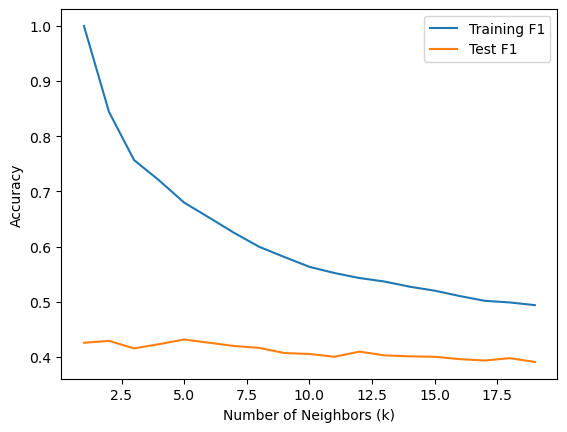

In [149]:
# select number of k for KNN, use only the F1 scores as indicator 

knn_train_F1_scores = []
knn_test_F1_scores = []
knn_auc = []
knn_gmeans = []

for k in range(1, 20):
    # Temporary lists to store accuracies for each fold at the current k
    knn_test_F1 = []
    knn_train_F1 = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Apply KNN Imputer to impute missing values
        X_fold_train_imputed = imputer.fit_transform(X_fold_train)
        X_fold_test_imputed = imputer.transform(X_fold_test)

        # Use SMOTE to balance the classes in y
        smote = SMOTE(random_state=100)
        resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

        # Train the KNN model with the current value of k
        knn_pip = Pipeline([("knn", KNeighborsClassifier(k))])
        knn_pip.fit(resampled_X, resample_y)

        # Predict
        knn_y_pred_train = knn_pip.predict(X_fold_train_imputed)
        knn_y_pred_test = knn_pip.predict(X_fold_test_imputed)

        # Evaluate and store the F1 scores for train and test sets
        knn_train_F1.append(accuracy_score(y_fold_train, knn_y_pred_train))
        knn_test_F1.append(accuracy_score(y_fold_test, knn_y_pred_test))

    # Store the average F1 score across folds for the current k
    knn_train_F1_scores.append(np.mean(knn_train_F1))
    knn_test_F1_scores.append(np.mean(knn_test_F1))

# Plotting the results for different k values after all k values are processed
plt.plot(range(1, 20), knn_train_F1_scores, label="Training F1")
plt.plot(range(1, 20), knn_test_F1_scores, label="Test F1")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [159]:
# Exclude KNN for further analysis due to its suboptimal performance in predicting the cancer type in Blood-cancer combined pancancer dataset
# optimize the number of the features used in the modeling: logistic regression (final choice after model comparing showed above)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

num_features = len(proteins)
num_splits = 5 # number of Kfold splits

# Initialize score arrays
log_accuracy_score = np.zeros((num_features, num_splits))
log_F1 = np.zeros((num_features, num_splits))
log_AUC = np.zeros((num_features, num_splits))
log_gmean = np.zeros((num_features, num_splits))

# Cross-validation loop
for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_fold_train = X_train.iloc[train_index]  # Use .iloc for DataFrames
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]

    # Apply KNN Imputer to impute missing values
    X_fold_train_imputed = imputer.fit_transform(X_fold_train)
    X_fold_test_imputed = imputer.transform(X_fold_test)

    # Convert X_fold_test_imputed back to a pandas DataFrame
    X_fold_test_imputed_df = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)

    # Apply SMOTE
    smote = SMOTE(random_state=100)
    resampled_X, resample_y = smote.fit_resample(X_fold_train_imputed, y_fold_train)

    # Convert resampled_X back to a pandas DataFrame
    resampled_X = pd.DataFrame(resampled_X, columns=X_fold_train.columns)

    for n in range(1, num_features + 1):  # Feature selection starts at 1
        # Select K best features
        selector = SelectKBest(score_func=f_classif, k=n)
        selector.fit(resampled_X, resample_y)

        # Get selected features
        selected_mask = selector.get_support()
        selected_features = resampled_X.columns[selected_mask]

        # Transform training and test data
        resampled_X_selected = resampled_X[selected_features] # training set X

        # Convert test set (NumPy array) to DataFrame and select features
        X_fold_test_selected = pd.DataFrame(X_fold_test_imputed, columns=X_fold_train.columns)[selected_features]

        # Train models
        log_pip = Pipeline([("log", LogisticRegression(penalty='l1', solver='liblinear', max_iter=500))])
        log_pip.fit(resampled_X_selected, resample_y)
 
        # Predict and evaluate logistic regression by various means
        log_y_pred = log_pip.predict(X_fold_test_selected)
        log_y_pred_proba = log_pip.predict_proba(X_fold_test_selected)
        log_fold_accuracy = accuracy_score(y_fold_test, log_y_pred)
        log_fold_gmean = geometric_mean_score(y_fold_test, log_y_pred, average='weighted')
        log_fold_auc = roc_auc_score(y_fold_test, log_y_pred_proba, multi_class='ovr', average='weighted')
        log_fold_f1 = f1_score(y_fold_test, log_y_pred, average='macro')

        log_accuracy_score[n - 1, i] = log_fold_accuracy
        log_gmean[n - 1, i] = log_fold_gmean
        log_AUC[n - 1, i] = log_fold_auc
        log_F1[n - 1, i] = log_fold_f1

In [ ]:
# convert the np.array into dataframe
log_accuracy_score_df = pd.DataFrame(log_accuracy_score)
log_F1_df = pd.DataFrame(log_f1s)
log_gmean_df = pd.DataFrame(log_gmean)
log_AUC_df = pd.DataFrame(log_AUC)


In [162]:
# add mean and std of 5 folds to new columns
log_F1_df['Mean'] = log_F1_df.mean(axis=1)
log_F1_df['Std'] = log_F1_df.std(axis=1)
log_accuracy_score_df['Mean'] = log_accuracy_score_df.mean(axis=1)
log_accuracy_score_df['Std'] = log_accuracy_score_df.std(axis=1)
log_gmean_df['Mean'] = log_gmean_df.mean(axis=1)
log_gmean_df['Std'] = log_gmean_df.std(axis=1)
log_AUC_df['Mean'] = log_AUC_df.mean(axis=1)
log_AUC_df['Std'] = log_AUC_df.std(axis=1)

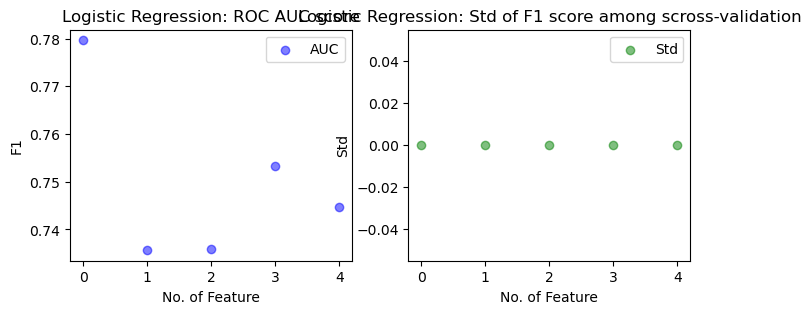

In [193]:
# Logistic Regression F1 scores
# First plot: Mean
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(range(len(log_F1_df['Mean'])), log_F1_df['Mean'], color='blue', alpha=0.5, label='AUC')
axes[0].set_title("Logistic Regression: ROC AUC score")
axes[0].set_xlabel("No. of Feature")
axes[0].set_ylabel("F1")
axes[0].legend()

# Second plot: Std
axes[1].scatter(range(len(log_F1_df['Std'])), log_F1_df['Std'], color='green', alpha=0.5, label='Std')
axes[1].set_title("Logistic Regression: Std of F1 score among scross-validation")
axes[1].set_xlabel("No. of Feature")
axes[1].set_ylabel("Std")
axes[1].legend()
# Display the plots
plt.show()

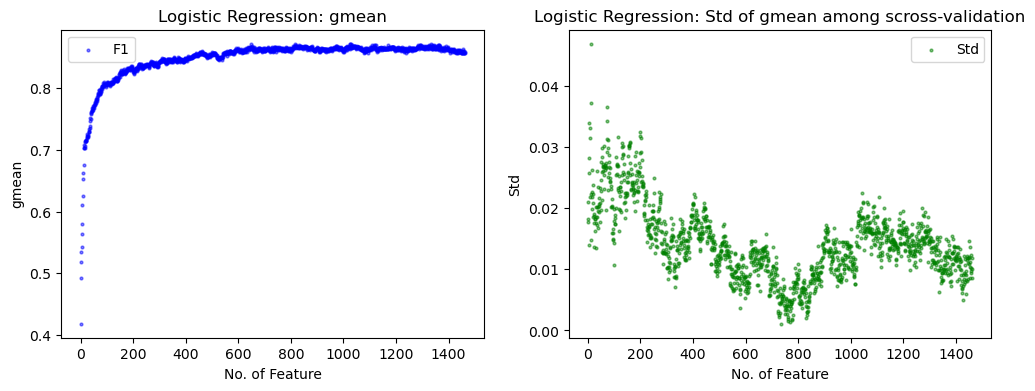

In [192]:
# Logistic Regression gmean scores
# First plot: Mean
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(range(len(log_gmean_df['Mean'])), log_gmean_df['Mean'], s = 4, color='blue', alpha=0.5, label='F1')
axes[0].set_title("Logistic Regression: gmean")
axes[0].set_xlabel("No. of Feature")
axes[0].set_ylabel("gmean")
axes[0].legend()

# Second plot: Std
axes[1].scatter(range(len(log_gmean_df['Std'])), log_gmean_df['Std'], s = 4, color='green', alpha=0.5, label='Std')
axes[1].set_title("Logistic Regression: Std of gmean among scross-validation")
axes[1].set_xlabel("No. of Feature")
axes[1].set_ylabel("Std")
axes[1].legend()

plt.show()

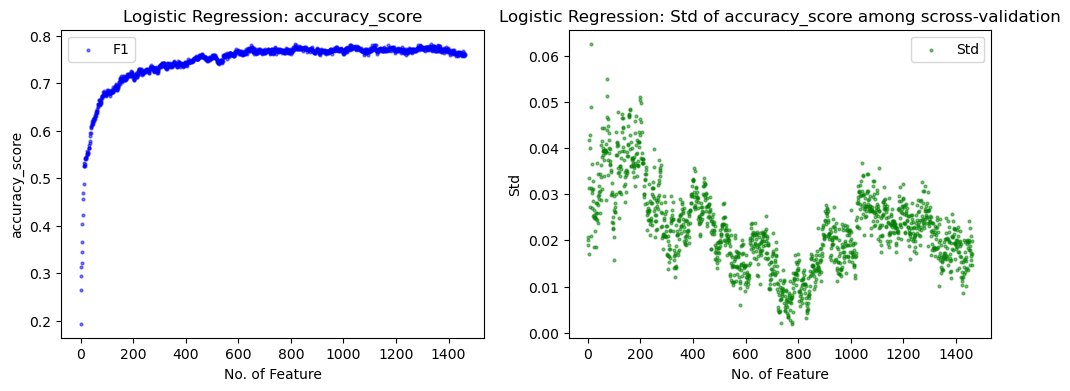

In [190]:
# Logistic Regression accuracy_score
# First plot: Mean
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(range(len(log_accuracy_score_df['Mean'])), log_accuracy_score_df['Mean'], s = 4, color='blue', alpha=0.5, label='F1')
axes[0].set_title("Logistic Regression: accuracy_score")
axes[0].set_xlabel("No. of Feature")
axes[0].set_ylabel("accuracy_score")
axes[0].legend()

# Second plot: Std
axes[1].scatter(range(len(log_accuracy_score_df['Std'])), log_accuracy_score_df['Std'], s = 4, color='green', alpha=0.5, label='Std')
axes[1].set_title("Logistic Regression: Std of accuracy_score among scross-validation")
axes[1].set_xlabel("No. of Feature")
axes[1].set_ylabel("Std")
axes[1].legend()

plt.show()

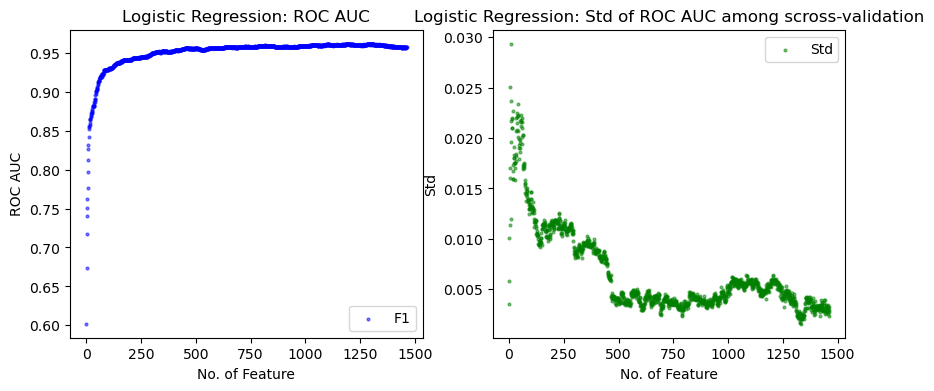

In [187]:
# Logistic Regression ROC AUC scores
# First plot: Mean
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(range(len(log_AUC_df['Mean'])), log_AUC_df['Mean'], color='blue', s = 4, alpha=0.5, label='F1')
axes[0].set_title("Logistic Regression: ROC AUC")
axes[0].set_xlabel("No. of Feature")
axes[0].set_ylabel("ROC AUC")
axes[0].legend()

# Second plot: Std
axes[1].scatter(range(len(log_AUC_df['Std'])), log_AUC_df['Std'], color='green', s = 4, alpha=0.5, label='Std')
axes[1].set_title("Logistic Regression: Std of ROC AUC among scross-validation")
axes[1].set_xlabel("No. of Feature")
axes[1].set_ylabel("Std")
axes[1].legend()

plt.show()